# Finding pairwise dissimilarity from Siamese Network
In this session we shall compare the faces of 18 persons. The face of each person is represented using a few photos (*mugshots*) of the person. 

A neural network is used to compute a **dissimilarity score** between the faces of every two persons through their photos. 

Finally, the dissimilarity scores are stored in a matrix, and used to construct a graph.

*(Neural network codes herein are modified from "https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch")*

**IMPORTANT: Submit your Google account name to enable file access and backup.**


---





##Test case name
Please set the variable "name" below to a name of your choice. <br>
Use any name, but please choose one (e.g. your name) that does not conflict with others' choices.<br>
You can use different names to identify different projects.<br>
**For the initial lab session, do not change this -- just leave this as "trial".**

In [0]:
# project name

name="trail"

## Imports

In [3]:
# Install PyTorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install torch torchvision

# Fix a problem with PIL which is unique only to colab

!pip install Pillow==4.0.0
!pip install image

# Install GCP modules

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

    100% |████████████████████████████████| 484.0MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b64e000 @  0x7f48e740e1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 1.3MB/s 
    100% |████████████████████████████████| 2.0MB 2.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.6MB 6.1MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0
    100% |████████████████████████████████| 7.1MB 4.0MB/s 
Preconfiguring packages .

In [0]:
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile
import random
import math
import copy
import os
import shutil
from google.colab import files, auth

## Helper functions

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()
    
# Set use_gcp to False to download a file to your local harddisk
def backup(filename, use_gcp=True):
    if name == "trial" and use_gcp: # No backup for the trial
        print("File \"" + filename + "\" not backed up since this is trial run.")
        return
    if use_gcp:
        project_id = 'twitter-for-bigquery'
        auth.authenticate_user()
        os.system("gcloud config set project twitter-for-bigquery")
        os.system("gsutil copy " + filename + " gs://harddisk-1/" + name + "/")
    else:
        files.download(filename)

# Set use_gcp to False to upload a file from your local harddisk
def restore(filename, use_gcp=True):
    if use_gcp:
        project_id = 'twitter-for-bigquery'
        auth.authenticate_user()
        os.system("gcloud config set project twitter-for-bigquery")
        os.system("gsutil copy gs://harddisk-1/" + name + "/" + filename + " .")
    else:
        if os.path.exists(filename):
            os.remove(filename)
        uploaded = files.upload()
    !ls -l {filename}

# Save graph for use in Gephi or pals
def export_edge_list(sim, labels=None, filename="edges.csv", delim=",", header=True):
    f = open(filename, 'w')
    if header:
        f.write("Source,Target\n")
    for i in range(sim.shape[0]):
        for j in range(i+1, sim.shape[1]):
            if sim[i,j] != 0:
                if labels == None:
                    f.write(str(i) + delim + str(j) + "\n")
                else:
                    f.write("\"" + labels[i] + "\"" + delim + "\"" + labels[j] + "\"\n")                          
    f.close()

# For preserving labels across sessions
def _save_labels(labels):
    f = open("_labels.csv", 'w')
    for i in range(len(labels)):
        f.write(str(i) + "," + labels[i] + "\n")
    f.close()
    backup("_labels.csv")

## Data preparation
You are to upload a file called "data.zip" to colab. Here's how you should prepare the file.<br>
**For the initial lab session, a ["data.zip" file](https://github.com/kalngyk/repoman/raw/master/data.zip) has been prepared. Simply run this section and it will be automatically used. (Just make sure that you have already submitted your Google account name.)**<br>
To prepare the file, obtain images (in jpg or png format) of several different classes. Each class of images should be of the same subject (e.g. a person's face, a car model). Images in the same class should be visually similar.<br>
About 5~10 images should be sufficient for each class, but each class must have the same number of images. You should have around 10~100 classes to generate a reasonably nice graph/network. <br>
Put your images for each class in a folder, and put all the folders in a folder called "data". Finally, compress the "data" folder into a zip archive called "data.zip".
See the provided ["data.zip" file](https://github.com/kalngyk/repoman/raw/master/data.zip) for reference.

*If you have fewer images for a certain class, you can duplicate the existing images of that class to make up the number.*

*If you see the error "<U>Upload widget is only available when the cell has been executed in the current browser session</U>", access the URL `chrome://settings/content/cookies` and disable "Block third-party cookies".*



In [6]:
# Retrieve data archive

use_backup = False # Set to True to use the backup copy of data.zip. This is useful when you redo the project.

if name == "trial" or use_backup:
    restore("buildinggray.zip")
else:
    restore("buildinggray.zip", False)

# Uncomment the following line to backup your data.zip. This is useful when you want to redo the project.

# backup("buildinggray.zip")

Saving buildinggray.zip to buildinggray.zip
-rw-r--r-- 1 root root 752894 Jul 25 01:10 buildinggray.zip


In [7]:
# Unzip data archive
! ls
if os.path.exists("buildinggray"):
    shutil.rmtree("buildinggray")
zip_ref = zipfile.ZipFile("buildinggray.zip", 'r')
zip_ref.extractall()
zip_ref.close()
classes = os.listdir("buildinggray")
print(len(classes), "classes found: ", end='')
for c in sorted(classes):
    print(c, end=' ')

buildinggray.zip  datalab
10 classes found: Baroque Luzon of Philippines Chinese royal garden French Gothic German Baroque German Gothic Italian Baroque Italian Gothic Japanese garden Romen style Suzhou gardens 

## Configuration

In [0]:
class Config():
    training_dir = "./buildinggray/"
    train_batch_size = 64
    train_number_epochs = 6
    labels = None

## Custom Dataset Class
A Dataset class supplies data into the SiameseNetwork. This dataset exhaustively enumerates all possible image pairs.

In [0]:
class PairwiseDataset(Dataset):

    def __init__(self, imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset    
        self.transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
        
    # If there are n classes in list, each of m images, then
    # Total number of images = n*m
    # Total number of pairs = (n*m)^2
    # Then i-th element should return element (i/nm, i%nm)
    # Note that both (i, j) and (j, i) will be included, although they are actually the same pair.
    def __getitem__(self, index):
        imgs = self.imageFolderDataset.imgs
        m = len([x for x in imgs if x[1] == 0])
        nm = len(imgs)
        n = int(nm/m)
        img0index = math.floor(index / nm)
        img1index = index % nm
        img0 = Image.open(imgs[img0index][0])
        img1 = Image.open(imgs[img1index][0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        same = np.array([int(imgs[img0index][1]!=imgs[img1index][1])], dtype=np.float32)
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(same)
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)*len(self.imageFolderDataset.imgs)


class RandomSampleDataset(Dataset):
    
    def __init__(self,imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset    
        self.transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Load input images into Dataset
At each stage each class is assigned a number, which will be used as the class' index in the dissimilarity matrix. <br>
To get the class name back from the index, we store the class names in *Config.labels*. <br>
*Config.labels[i]* will give us the class name for the index *i*.

In [10]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = PairwiseDataset(imageFolderDataset=folder_dataset)
idx2label = {y: os.path.basename(os.path.dirname(x)) for (x, y) in folder_dataset.imgs}
Config.labels = [idx2label[key] for key in sorted(idx2label.keys())]
print(Config.labels)
print("Loaded images of", len(Config.labels), "classes into Dataset. Class names are now stored in Config.labels")

['Baroque Luzon of Philippines', 'Chinese royal garden', 'French Gothic', 'German Baroque', 'German Gothic', 'Italian Baroque', 'Italian Gothic', 'Japanese garden', 'Romen style', 'Suzhou gardens']
Loaded images of 10 classes into Dataset. Class names are now stored in Config.labels


In [0]:
# Save labels for later use (e.g. community detection)

_save_labels(Config.labels)

## Examine data
Randomly get a few pairs of images from the Dataset to see if they are what you uploaded.<br>
The top row and the bottom row of any column is one pair. <br>
For each pair,
1 = different class, 0 = same class. (The majority of the pairs will be of type 1.)

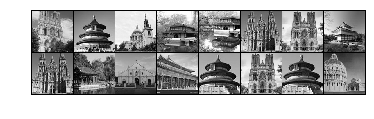

[1. 0. 1. 1. 1. 1. 1. 1.]


In [12]:
vis_dataloader = DataLoader(siamese_dataset,shuffle=True,batch_size=8)

dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape((-1,)))

## Define the SiameseNetwork

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Train the neural network

 Epoch 0 Batch 0/225: loss = 3.2061610221862793
 Epoch 0 Batch 27/225: loss = 0.7154715061187744
 Epoch 0 Batch 54/225: loss = 0.46898674964904785
 Epoch 0 Batch 81/225: loss = 0.7290369272232056
 Epoch 0 Batch 108/225: loss = 0.7443530559539795
 Epoch 0 Batch 135/225: loss = 0.7667088508605957
 Epoch 0 Batch 162/225: loss = 0.6228225231170654
 Epoch 0 Batch 189/225: loss = 0.6761469841003418
 Epoch 0 Batch 216/225: loss = 0.7299770712852478
 Epoch 1 Batch 0/225: loss = 0.4116865396499634
 Epoch 1 Batch 27/225: loss = 0.6730843782424927
 Epoch 1 Batch 54/225: loss = 0.6329509615898132
 Epoch 1 Batch 81/225: loss = 0.4601778984069824
 Epoch 1 Batch 108/225: loss = 0.3976603150367737
 Epoch 1 Batch 135/225: loss = 0.8348859548568726
 Epoch 1 Batch 162/225: loss = 0.45485609769821167
 Epoch 1 Batch 189/225: loss = 0.6373515725135803
 Epoch 1 Batch 216/225: loss = 0.6269132494926453
 Epoch 2 Batch 0/225: loss = 0.8072328567504883
 Epoch 2 Batch 27/225: loss = 0.7476115226745605
 Epoch 2 Ba

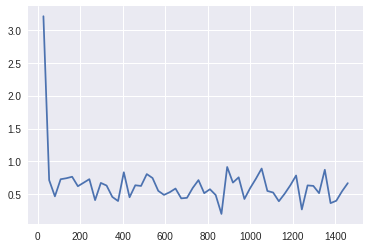

In [15]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=Config.train_batch_size)
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)
counter = []
loss_history = [] 
interval_num = 0
batches_per_epoch = int(len(siamese_dataset) / Config.train_batch_size)
total_batches = batches_per_epoch * Config.train_number_epochs
num_intervals = 50
num_batches_per_interval = int(total_batches / num_intervals)
for epoch in range(0, Config.train_number_epochs):
    for batch, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if batch % num_batches_per_interval == 0:
            print(" Epoch {} Batch {}/{}: loss = {}".format(epoch, batch, batches_per_epoch, loss_contrastive.item()))
            interval_num += num_batches_per_interval
            counter.append(interval_num)
            loss_history.append(loss_contrastive.item())
show_plot(counter, loss_history)

# Saves the trained SiameseNetwork

trained_model = copy.deepcopy(net.state_dict())
torch.save(trained_model, "siamese.pth")

# Comment out the following line to stop automatic backup of the trained model file

backup("siamese.pth")

In [0]:
# Manually backup the trained model file to GCP

backup("siamese.pth")

#####Non-GPU version of the training:

In [0]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=Config.train_batch_size)
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)
counter = []
loss_history = [] 
interval_num = 0
batches_per_epoch = int(len(siamese_dataset) / Config.train_batch_size)
total_batches = batches_per_epoch * Config.train_number_epochs
num_intervals = 50
num_batches_per_interval = int(total_batches / num_intervals)
for epoch in range(0, Config.train_number_epochs):
    for batch, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0, img1, Variable(label)
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if batch % num_batches_per_interval == 0:
            print(" Epoch {} Batch {}/{}: loss = {}".format(epoch, batch, batches_per_epoch, loss_contrastive.item()))
            interval_num += num_batches_per_interval
            counter.append(interval_num)
            loss_history.append(loss_contrastive.item())
show_plot(counter, loss_history)

# Saves the trained SiameseNetwork

trained_model = copy.deepcopy(net.state_dict())
torch.save(trained_model, "siamese.pth")

# Comment out the following line to stop automatic backup of the trained model file

backup("siamese.pth")

## Compute pairwise dissimilarities of all images using the trained neural network
Compute the dissimilarities between pairwise images in the training set. The dissimilarity between two persons is then calculated as the sum of the dissimilaries between their mugshots. 
Finally, the dissimilarities between every pair of persons are stored in dissimilarity matrix.

In [44]:
# Load a saved copy of the trained SiameseNetwork

restore("siamese.pth")

net = SiameseNetwork().cuda()   # "net=SiameseNetwork()" to use without GPU
net.load_state_dict(torch.load("siamese.pth"))

-rw-r--r-- 1 root root 161021349 Jul 25 02:46 siamese.pth


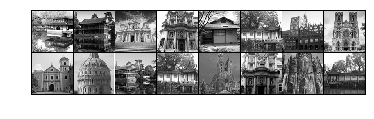

[1.98, 1.94, 2.65, 1.17, 0.83, 1.73, 1.71, 2.21]


In [18]:
# Check the performance of the trained network

vis_dataloader = DataLoader(siamese_dataset,shuffle=True,batch_size=8)

dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]), 0)
distance = []
for i in range(8):
    x0 = example_batch[0][i]
    x1 = example_batch[1][i]
    output1, output2 = net(x0[None, :, :].cuda(), x1[None, :, :].cuda())
    distance.append(F.pairwise_distance(output1, output2).cpu().detach().numpy())
distance = [round(item, 2) for sublist in distance for item in sublist]

imshow(torchvision.utils.make_grid(concatenated))
print(distance)

In [19]:
# Find pairwise matrix of dissimilarity between classes in training_set
folder = dset.ImageFolder(root=Config.training_dir)
transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])

img_per_class = len([x for x in folder.imgs if x[1] == 0])
nclasses = int(len(folder.imgs)/img_per_class)
sim = np.zeros((nclasses, nclasses))

for t0 in folder.imgs:
    for t1 in folder.imgs:
        c0 = t0[1]
        c1 = t1[1]
        x0 = Image.open(t0[0])
        x1 = Image.open(t1[0])
        x0 = transform(x0.convert("L"))
        x1 = transform(x1.convert("L"))
        img0 = x0[None, :, :].cuda()
        img1 = x1[None, :, :].cuda()
        output1, output2 = net(img0,img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        sim[c0,c1] += euclidean_distance.cpu().detach().numpy()
        
np.savetxt('_sim.txt', sim)
print("Generated {}x{} matrix".format(sim.shape[0], sim.shape[1]))

Generated 10x10 matrix


In [0]:
# Save the dissimilarity matrix across session

backup("_sim.txt")

## Build graph/network
Build graph/network from the dissimilarity matrix.<br>
A more elaborated version of this is in the next session: "**Community Detection**", where we will use the module NetworkX to visualize and analyze the network.

In [21]:
# Load a saved copy of the dissimilarity matrix

restore('_sim.txt')

sim = np.loadtxt('_sim.txt')

print("Restored {}x{} matrix".format(sim.shape[0], sim.shape[1]))

-rw-r--r-- 1 root root 2500 Jul 25 01:20 _sim.txt
Restored 10x10 matrix


diagonal avg=255.14 min=164.05 max=330.98


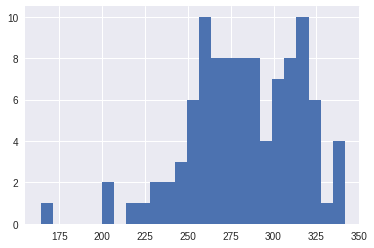

In [22]:
# Analyze distribution of dissimilarity score

d = np.diagonal(sim)
print('diagonal avg={0:.2f} min={1:.2f} max={2:.2f}'.format(np.mean(d), np.min(d), np.max(d)))
simflat = sim.reshape((-1,))
_ = plt.hist(simflat, bins=25)

In [34]:
# Select a suitable threshold and set dissimilarity scores larger than that threshold to zero

threshold = 290
adjmat = sim.reshape((-1,)).copy()
adjmat[adjmat > threshold] = 0
print("{} out of {} values set to zero".format(len(adjmat[adjmat == 0]), len(adjmat)))
adjmat = adjmat.reshape(sim.shape)

44 out of 100 values set to zero


##Output edges for visualization in Gephi

Gephi Download - https://gephi.org/users/download/<br>
Gephi HOWTO    - https://gephi.wordpress.com/2017/09/26/gephi-0-9-2-a-new-csv-importer/


In [0]:
# Generate and download edges for Gephi

export_edge_list(adjmat, labels=Config.labels, filename='gephi-edges.csv')
backup('gephi-edges.csv', False)

In [0]:
import networkx as nx
# Creates a NetworkX graph object
def make_graph(sim, labels=None):
    G = nx.Graph()
    for i in range(sim.shape[0]):
        for j in range(sim.shape[1]):
            if i != j and sim[i,j] != 0:
                if labels == None:
                    G.add_edge(i, j, weight=sim[i,j])
                else:
                    G.add_edge(labels[i], labels[j], weight=sim[i,j])
    return G    


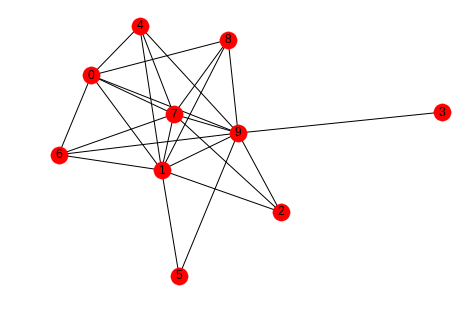

In [46]:
# Construct a networkx graph from the adjacency matrix
# (Singleton nodes are excluded from the graph)

G = make_graph(adjmat, labels=Config.labels)
nx.draw_spring(G, with_labels=True)



In [41]:
# -*- coding: utf-8 -*-
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt
 
def hierarchy_cluster(data, method='single', threshold=300):
    '''层次聚类
    
    Arguments:
        data [[0, float, ...], [float, 0, ...]] -- 文档 i 和文档 j 的距离
    
    Keyword Arguments:
        method {str} -- [linkage的方式： single、complete、average、centroid、median、ward] (default: {'average'})
        threshold {float} -- 聚类簇之间的距离
    Return:
        cluster_number int -- 聚类个数
        cluster [[idx1, idx2,..], [idx3]] -- 每一类下的索引
    '''
    data = np.array(data)
 
    Z = linkage(data, method=method)
    cluster_assignments = fcluster(Z, threshold, criterion='distance')
    #print type(cluster_assignments)
    num_clusters = cluster_assignments.max()
    indices = get_cluster_indices(cluster_assignments)
 
    return num_clusters, indices
 
 
 
def get_cluster_indices(cluster_assignments):
    '''映射每一类至原数据索引
    
    Arguments:
        cluster_assignments 层次聚类后的结果
    
    Returns:
        [[idx1, idx2,..], [idx3]] -- 每一类下的索引
    '''
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    
    return indices
 
 
if __name__ == '__main__':
    
 
    arr = adjmat
 
    arr = np.array(arr)
    r, c = arr.shape
    for i in range(r):
        for j in range(i, c):
            if arr[i][j] != arr[j][i]:
                arr[i][j] = arr[j][i]
    for i in range(r):
        for j in range(i, c):
            if arr[i][j] != arr[j][i]:
                print(arr[i][j], arr[j][i])
 
    num_clusters, indices = hierarchy_cluster(arr)
 
 
    print("%d clusters" % num_clusters)
    for k, ind in enumerate(indices):
        print ("cluster", k + 1, "is", ind)

6 clusters
cluster 1 is [3 5]
cluster 2 is [2]
cluster 3 is [0 1 7 9]
cluster 4 is [4]
cluster 5 is [8]
cluster 6 is [6]


In [0]:
class Config():
    colors = ['aquamarine', 'bisque', 'blanchedalmond', 'blueviolet', 'brown',
              'burlywood', 'cadetblue', 'chartreuse','chocolate', 'coral',
              'cornflowerblue', 'cornsilk', 'crimson', 'darkblue', 'darkcyan',
              'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
              'darkmagenta', 'darkolivegreen', 'darkorange', 'darkslateblue',
              'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
              'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet',
              'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue',
              'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
              'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow',
              'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory']
    labels = None

Possibility 1 : ({0, 1, 2, 4, 5, 6, 7, 8, 9}, {3})


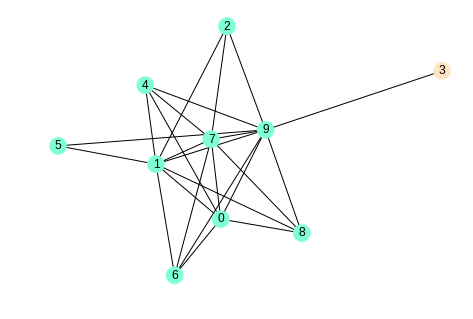

Possibility 2 : ({0, 1, 2, 4, 6, 7, 8, 9}, {5}, {3})


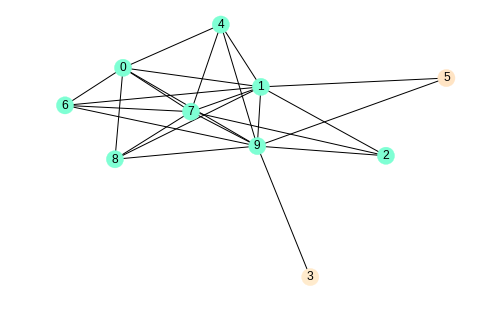

Possibility 3 : ({0, 1, 4, 6, 7, 8, 9}, {2}, {5}, {3})


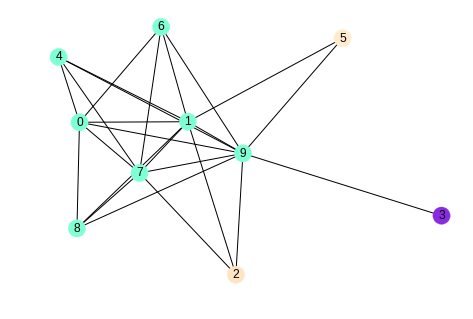

Possibility 4 : ({0, 1, 6, 7, 8, 9}, {4}, {2}, {5}, {3})


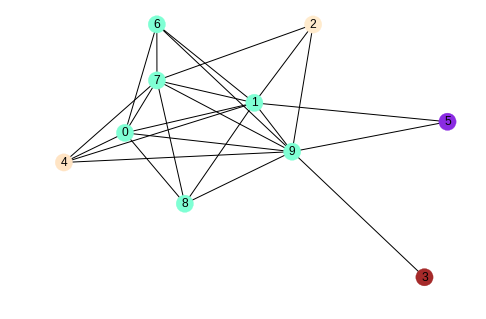

Possibility 5 : ({0, 1, 7, 8, 9}, {4}, {6}, {2}, {5}, {3})


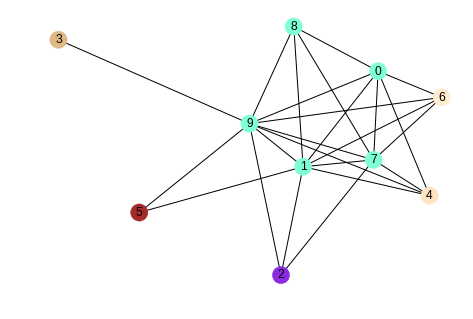

In [42]:
import itertools
from networkx.algorithms.community.centrality import girvan_newman

comp = girvan_newman(G)

max_shown = 5
shown_count = 1
possibilities = []
for communities in itertools.islice(comp, max_shown):
    print("Possibility", shown_count, ": ", end='')
    print(communities)
    possibilities.append(communities)
    color_map = ["" for x in range(len(G))]
    color = 0
    for c in communities:
        indices = [i for i, x in enumerate(G.nodes) if x in c]
        for i in indices:
            color_map[i] = Config.colors[color]
        color += 1
    shown_count += 1
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()
